In [42]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import iris
import iris.quickplot as qplt
import iris.plot as iplt
#from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
from sklearn import metrics
from nc_processing import calc_spatial_mean
from tqdm import tqdm

#sns.set()

from xmip.preprocessing import rename_cmip6
import matplotlib.path as mpath
import glob

ens_mems = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']

baseline_adjustment = 0.02 # mm per day
window_length = 20

In [41]:
### get crossing year from pre-calculated ssp245 tas projections
df = pd.read_csv('co2mass_at_crit_temp.csv')
df_base = df[df['Ensemble_member'].isin(ens_mems)]
df_base = df_base[df_base['Scenario']=='ssp245']
print(df_base)
crossing_year = np.mean(df_base['Crossing_year_1.5'])
print(crossing_year)

    Unnamed: 0      Rate       co2mass Scenario Ensemble_member  \
24          18  0.045029  1.080452e+15   ssp245        r1i1p1f2   
25          19  0.061249  1.094856e+15   ssp245        r2i1p1f2   
26          20  0.037271  1.073707e+15   ssp245        r3i1p1f2   
27          21  0.051492  1.107791e+15   ssp245        r4i1p1f2   
28          22  0.042800  1.027977e+15   ssp245        r8i1p1f2   

    Crossing_year_1.5  Order  
24        2023.336945      4  
25        2023.975259      4  
26        2023.038058      4  
27        2024.538596      4  
28        2020.969127      4  
2023.1715966531428


In [27]:
### get ensemble mean pr for both scenarios 

ds_list_pr = []
paths_pr = glob.glob('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/*/Amon/pr/gn/*/')

for path in paths_pr:
    #files = os.listdir(path)
    ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
    ds_list_pr.append(ds)

DS_ARISE_pr = xr.concat(ds_list_pr, dim='Ensemble_member')

# make SSP245 ensemble mean pr ds
def get_ssp245_ds(variable, table='Amon', grid='gn'):
    ds_list = []
    for es in ens_mems:
        path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/{e}/{t}/{v}/{g}/latest/'.format(e=es, t=table,v=variable, g=grid)
        #files = os.listdir(path)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        
        path_hist = glob.glob('/badc/cmip6/data/CMIP6/*/*/UKESM1-0-LL/historical/{e}/{t}/{v}/*/latest/'.format(
        t=table, v=variable, e=es))[0]
        ds_hist = rename_cmip6(xr.open_mfdataset(path_hist+'*.nc'))
        #ds = read_in(folder_pr)
            
        ds = xr.concat([ds_hist, ds], dim='time')
        ds = ds.sel(time=slice('1990', '2150'))
        
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS
    
DS_ssp245_pr = get_ssp245_ds(variable='pr', table='Amon')



In [28]:
### group to get annual mean pr
DS_ssp245_pr = DS_ssp245_pr.groupby('time.year').mean('time')
DS_ARISE_pr = DS_ARISE_pr.groupby('time.year').mean('time')

In [29]:
DS_ssp245_pr

,Array,Chunk
Bytes,1.22 MiB,2.25 kiB
Shape,"(111, 5, 144, 2)","(1, 1, 144, 2)"
Count,2920 Tasks,555 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.63 MiB,3.00 kiB
Shape,"(111, 5, 192, 2)","(1, 1, 192, 2)"
Count,2920 Tasks,555 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [30]:
da_ssp245 = calc_spatial_mean(DS_ssp245_pr['pr'], lon_name="x", lat_name="y")
da_arise = calc_spatial_mean(DS_ARISE_pr['pr'], lon_name="x", lat_name="y")

DF_ssp = pd.DataFrame({'Year':DS_ssp245_pr['year'].values,
                       'pr_em':da_ssp245.mean(dim='Ensemble_member').values})
DF_ARISE = pd.DataFrame({'Year':DS_ARISE_pr['year'].values,
                       'pr_em':da_arise.mean(dim='Ensemble_member').values})

In [31]:
da_ssp245.groupby('Ensemble_member')

DataArrayGroupBy, grouped over 'Ensemble_member'
5 groups with labels 0, 1, 2, 3, 4.

In [32]:
for i in np.arange(0, 5, 1):
    da_ssp245_i = da_ssp245.groupby('Ensemble_member')[i]
    da_ARISE_i = da_arise.groupby('Ensemble_member')[i]

    DF_ssp['pr_{}'.format(i)] = da_ssp245_i.values
    DF_ARISE['pr_{}'.format(i)] = da_ARISE_i.values

3.1362720566200104
3.1562720566200104


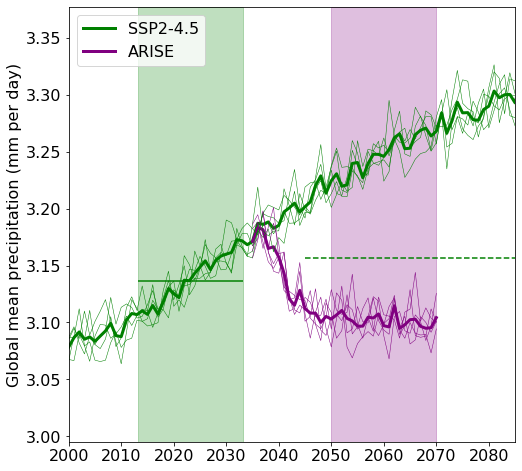

In [64]:
unit_conversion = 86400
matplotlib.rcParams.update({'font.size': 16})

ssp245_col = 'green'
arise_col = 'purple'

fig, pr_ax = plt.subplots(figsize=(8, 8))

pr_ax.plot(DF_ssp['Year'], DF_ssp['pr_em']*unit_conversion,
            color = ssp245_col, label='SSP2-4.5', lw=3)
pr_ax.plot(DF_ARISE['Year'], DF_ARISE['pr_em']*unit_conversion,
            color=arise_col, label='ARISE', lw=3)

for i in np.arange(0, 5, 1):
    pr_ax.plot(DF_ssp['Year'], DF_ssp['pr_{}'.format(i)]*unit_conversion,
            color = ssp245_col, lw=0.5)
    pr_ax.plot(DF_ARISE['Year'], DF_ARISE['pr_{}'.format(i)]*unit_conversion,
            color=arise_col, lw=0.5)

pr_ax.set_xlim([2000, 2085])
#pr_ax.set_ylim([1.8, 10])
pr_ax.set_ylabel('Global mean precipitation (mm per day)')
pr_ax.legend(loc='upper left')



DF_ARISE['pr_em_rm'] = DF_ARISE['pr_em'].rolling(window=window_length, center=True).mean()
DF_ssp['pr_em_rm'] = DF_ssp['pr_em'].rolling(window=window_length, center=True).mean()
transient_base = np.interp(crossing_year, DF_ssp['Year'], DF_ssp['pr_em_rm'])*86400
print(transient_base)

QE_base = transient_base + baseline_adjustment
print(QE_base)

pr_ax.hlines(transient_base, color=ssp245_col,
             xmin = (crossing_year-window_length/2), 
             xmax = (crossing_year+window_length/2))
pr_ax.hlines(QE_base, color=ssp245_col, ls='--',
             xmin = 2045, 
             xmax = 2090)
pr_ax.axvspan((crossing_year-window_length/2), (crossing_year+window_length/2), color=ssp245_col, alpha=0.25)
pr_ax.axvspan(2050, 2070, color=arise_col, alpha=0.25)


plt.savefig('Figures/UKESM_ARISE_Pr_against_diff_baselines.jpg', dpi=400)

plt.show()